## Phase 1 - Project Setup ##

In [1]:
# imports
%config InlineBackend.figure_format = 'retina'

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.pipeline import Pipeline

In [2]:
df = pd.read_csv("songs.csv", encoding="latin-1") # Loads csv file
df.head() # Displays first few rows in csv

,track_name,artist(s)_name,artist_count,released_year,released_month,released_day,in_spotify_playlists,in_spotify_charts,streams,in_apple_playlists,...,bpm,key,mode,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%
0,Seven (feat. Latto) (Explicit Ver.),"Latto, Jung Kook",2,2023,7,14,553,147,141381703,43,...,125,B,Major,80,89,83,31,0,8,4
1,LALA,Myke Towers,1,2023,3,23,1474,48,133716286,48,...,92,C#,Major,71,61,74,7,0,10,4
2,vampire,Olivia Rodrigo,1,2023,6,30,1397,113,140003974,94,...,138,F,Major,51,32,53,17,0,31,6
3,Cruel Summer,Taylor Swift,1,2019,8,23,7858,100,800840817,116,...,170,A,Major,55,58,72,11,0,11,15
4,WHERE SHE GOES,Bad Bunny,1,2023,5,18,3133,50,303236322,84,...,144,A,Minor,65,23,80,14,63,11,6


In [3]:
df.describe() # Generates descriptive statistics

,artist_count,released_year,released_month,released_day,in_spotify_playlists,in_spotify_charts,in_apple_playlists,in_apple_charts,in_deezer_charts,bpm,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%
count,953.000000,953.000000,953.000000,953.000000,953.000000,953.000000,953.000000,953.000000,953.000000,953.000000,953.00000,953.000000,953.000000,953.000000,953.000000,953.000000,953.000000
mean,1.556139,2018.238195,6.033578,13.930745,5200.124869,12.009444,67.812172,51.908709,2.666317,122.540399,66.96957,51.431270,64.279119,27.057712,1.581322,18.213012,10.131165
std,0.893044,11.116218,3.566435,9.201949,7897.608990,19.575992,86.441493,50.630241,6.035599,28.057802,14.63061,23.480632,16.550526,25.996077,8.409800,13.711223,9.912888
min,1.000000,1930.000000,1.000000,1.000000,31.000000,0.000000,0.000000,0.000000,0.000000,65.000000,23.00000,4.000000,9.000000,0.000000,0.000000,3.000000,2.000000
25%,1.000000,2020.000000,3.000000,6.000000,875.000000,0.000000,13.000000,7.000000,0.000000,100.000000,57.00000,32.000000,53.000000,6.000000,0.000000,10.000000,4.000000
50%,1.000000,2022.000000,6.000000,13.000000,2224.000000,3.000000,34.000000,38.000000,0.000000,121.000000,69.00000,51.000000,66.000000,18.000000,0.000000,12.000000,6.000000
75%,2.000000,2022.000000,9.000000,22.000000,5542.000000,16.000000,88.000000,87.000000,2.000000,140.000000,78.00000,70.000000,77.000000,43.000000,0.000000,24.000000,11.000000
max,8.000000,2023.000000,12.000000,31.000000,52898.000000,147.000000,672.000000,275.000000,58.000000,206.000000,96.00000,97.000000,97.000000,97.000000,91.000000,97.000000,64.000000


In [4]:
df.isnull() # Checks for missing values

,track_name,artist(s)_name,artist_count,released_year,released_month,released_day,in_spotify_playlists,in_spotify_charts,streams,in_apple_playlists,...,bpm,key,mode,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
948,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
949,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
950,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
951,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [5]:
df.columns

Index(['track_name', 'artist(s)_name', 'artist_count', 'released_year',
       'released_month', 'released_day', 'in_spotify_playlists',
       'in_spotify_charts', 'streams', 'in_apple_playlists', 'in_apple_charts',
       'in_deezer_playlists', 'in_deezer_charts', 'in_shazam_charts', 'bpm',
       'key', 'mode', 'danceability_%', 'valence_%', 'energy_%',
       'acousticness_%', 'instrumentalness_%', 'liveness_%', 'speechiness_%'],
      dtype='object')

In [6]:
df.dtypes # Gets the type of each column

track_name              object
artist(s)_name          object
artist_count             int64
released_year            int64
released_month           int64
released_day             int64
in_spotify_playlists     int64
in_spotify_charts        int64
streams                 object
in_apple_playlists       int64
in_apple_charts          int64
in_deezer_playlists     object
in_deezer_charts         int64
in_shazam_charts        object
bpm                      int64
key                     object
mode                    object
danceability_%           int64
valence_%                int64
energy_%                 int64
acousticness_%           int64
instrumentalness_%       int64
liveness_%               int64
speechiness_%            int64
dtype: object

In [7]:
df.isnull().sum() 

track_name               0
artist(s)_name           0
artist_count             0
released_year            0
released_month           0
released_day             0
in_spotify_playlists     0
in_spotify_charts        0
streams                  0
in_apple_playlists       0
in_apple_charts          0
in_deezer_playlists      0
in_deezer_charts         0
in_shazam_charts        50
bpm                      0
key                     95
mode                     0
danceability_%           0
valence_%                0
energy_%                 0
acousticness_%           0
instrumentalness_%       0
liveness_%               0
speechiness_%            0
dtype: int64

In [8]:
audio_features = [
    "bpm",
    "danceability_%",
    "valence_%",
    "energy_%",
    "acousticness_%",
    "instrumentalness_%",
    "liveness_%",
    "speechiness_%"
]

Clustering songs based on similarity to each other. Clustering with audio characteristics creates usable clusters for:

* mood based recommendations
* playlist generation
* discovering similar sounding artists
* personalization 


In [9]:
# Keep metadata with audio features and drop rows with missing values
spotify_df = df[["track_name", "artist(s)_name"] + audio_features].dropna().copy()

X = spotify_df[audio_features].values

spotify_df.head()

,track_name,artist(s)_name,bpm,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%
0,Seven (feat. Latto) (Explicit Ver.),"Latto, Jung Kook",125,80,89,83,31,0,8,4
1,LALA,Myke Towers,92,71,61,74,7,0,10,4
2,vampire,Olivia Rodrigo,138,51,32,53,17,0,31,6
3,Cruel Summer,Taylor Swift,170,55,58,72,11,0,11,15
4,WHERE SHE GOES,Bad Bunny,144,65,23,80,14,63,11,6


## Phase 2 - Find K Value ##

In [10]:
k_values = range(2, 11) # K values from 2 to 10
inertias = []            
sil_scores = []           

for k in k_values:
    pipe = Pipeline([
        ('scale', StandardScaler()),
        ('kmeancl', KMeans(n_clusters=k, random_state=0))
    ])
    labels_k = pipe.fit_predict(X)
    
    # Elbow inertia
    inertias.append(pipe.named_steps['kmeancl'].inertia_)
    
    # Silhouette score
    score_k = silhouette_score(X, labels_k)
    sil_scores.append(score_k)
    
    print(f"k = {k}, inertia = {pipe.named_steps['kmeancl'].inertia_:.2f}, silhouette = {score_k:.4f}")


k = 2, inertia = 6348.17, silhouette = 0.2355
k = 3, inertia = 5702.99, silhouette = 0.1645
k = 4, inertia = 5092.90, silhouette = 0.1517
k = 5, inertia = 4644.36, silhouette = 0.1325
k = 6, inertia = 3947.29, silhouette = 0.1328
k = 7, inertia = 3678.60, silhouette = 0.1368
k = 8, inertia = 3544.10, silhouette = 0.1191
k = 9, inertia = 3393.60, silhouette = 0.1264
k = 10, inertia = 3292.76, silhouette = 0.1099


The elbow occurs at k = 3 because it is the first point where increasing k results in a decreasing value. 

k = 2 gives the highest silhouette score, but its not useful because it only splits the dataset into 2 giant clusters. K = 3 gives the next best score. The silhouette steadily declines after k = 3 resulting in the clusters becoming noisier and less separated.

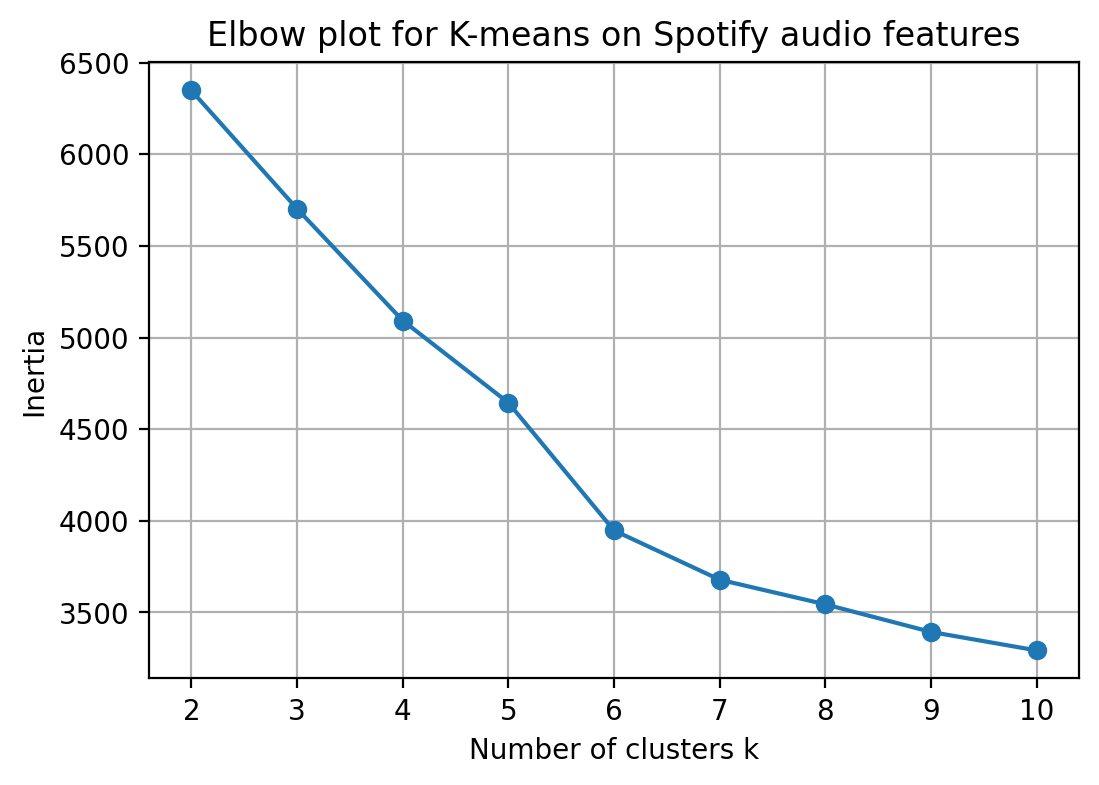

In [11]:
plt.figure(figsize=(6, 4))
plt.plot(list(k_values), inertias, marker='o')
plt.xlabel("Number of clusters k")
plt.ylabel("Inertia")
plt.title("Elbow plot for K-means on Spotify audio features")
plt.grid(True)
plt.show()

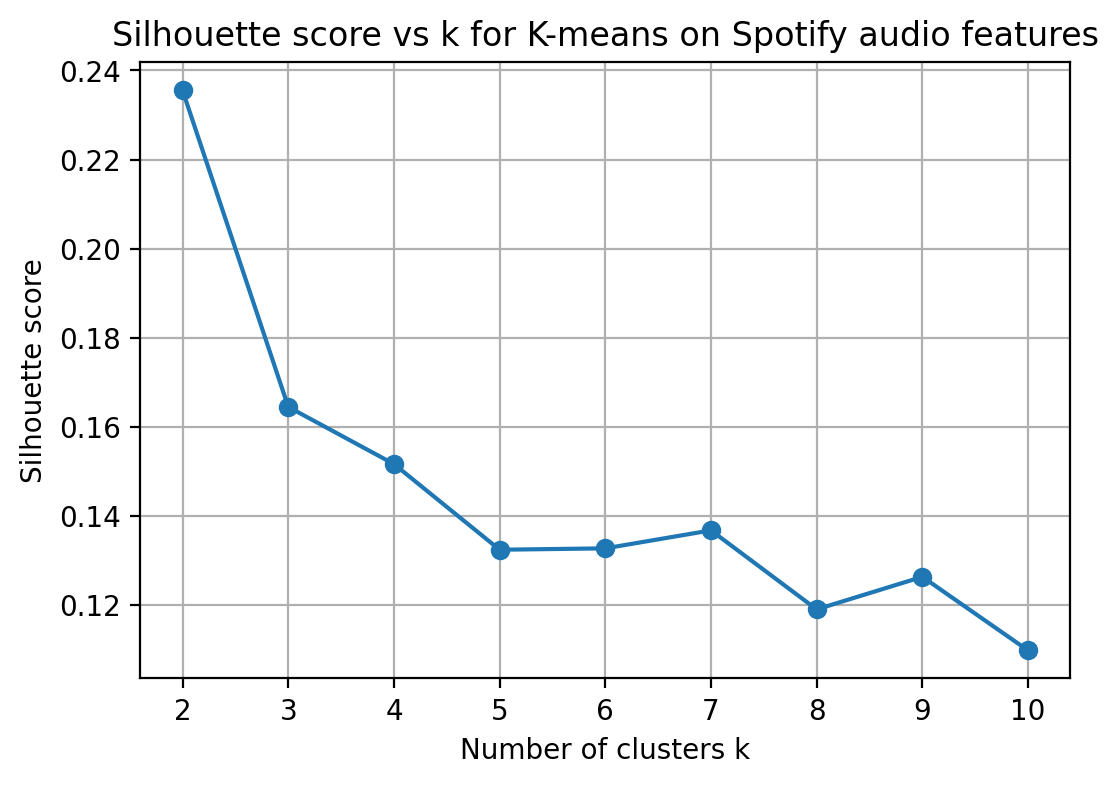

In [12]:
plt.figure(figsize=(6, 4))
plt.plot(list(k_values), sil_scores, marker='o')
plt.xlabel("Number of clusters k")
plt.ylabel("Silhouette score")
plt.title("Silhouette score vs k for K-means on Spotify audio features")
plt.grid(True)
plt.show()

K = 3 because:

* It is the clearest elbow with the first major shape change
* Gives the best balance of cluster quality and interpretability
* Produces clusters that are distinct, easy to interpret, useful for reccomendation, and is validated by both elbow and silhouette plots

## Phase 3 - Fit K-Means model with scaling (pipeline) ##

In [13]:
BEST_K = 3 # Chosen k value

cl_pipe = Pipeline([
    ('scale', StandardScaler()), 
    ('kmeancl', KMeans(n_clusters=BEST_K, random_state=0)) # Uses KMeans operator with chosen cluster number 
])

# Fit pipeline and get cluster labels
spotify_df["cluster_label"] = cl_pipe.fit_predict(X)

print("Cluster label counts:")
print(spotify_df["cluster_label"].value_counts().sort_index())

Cluster label counts:
cluster_label
0    194
1    430
2    329
Name: count, dtype: int64


## Phase 4 - Visualize clusters ##

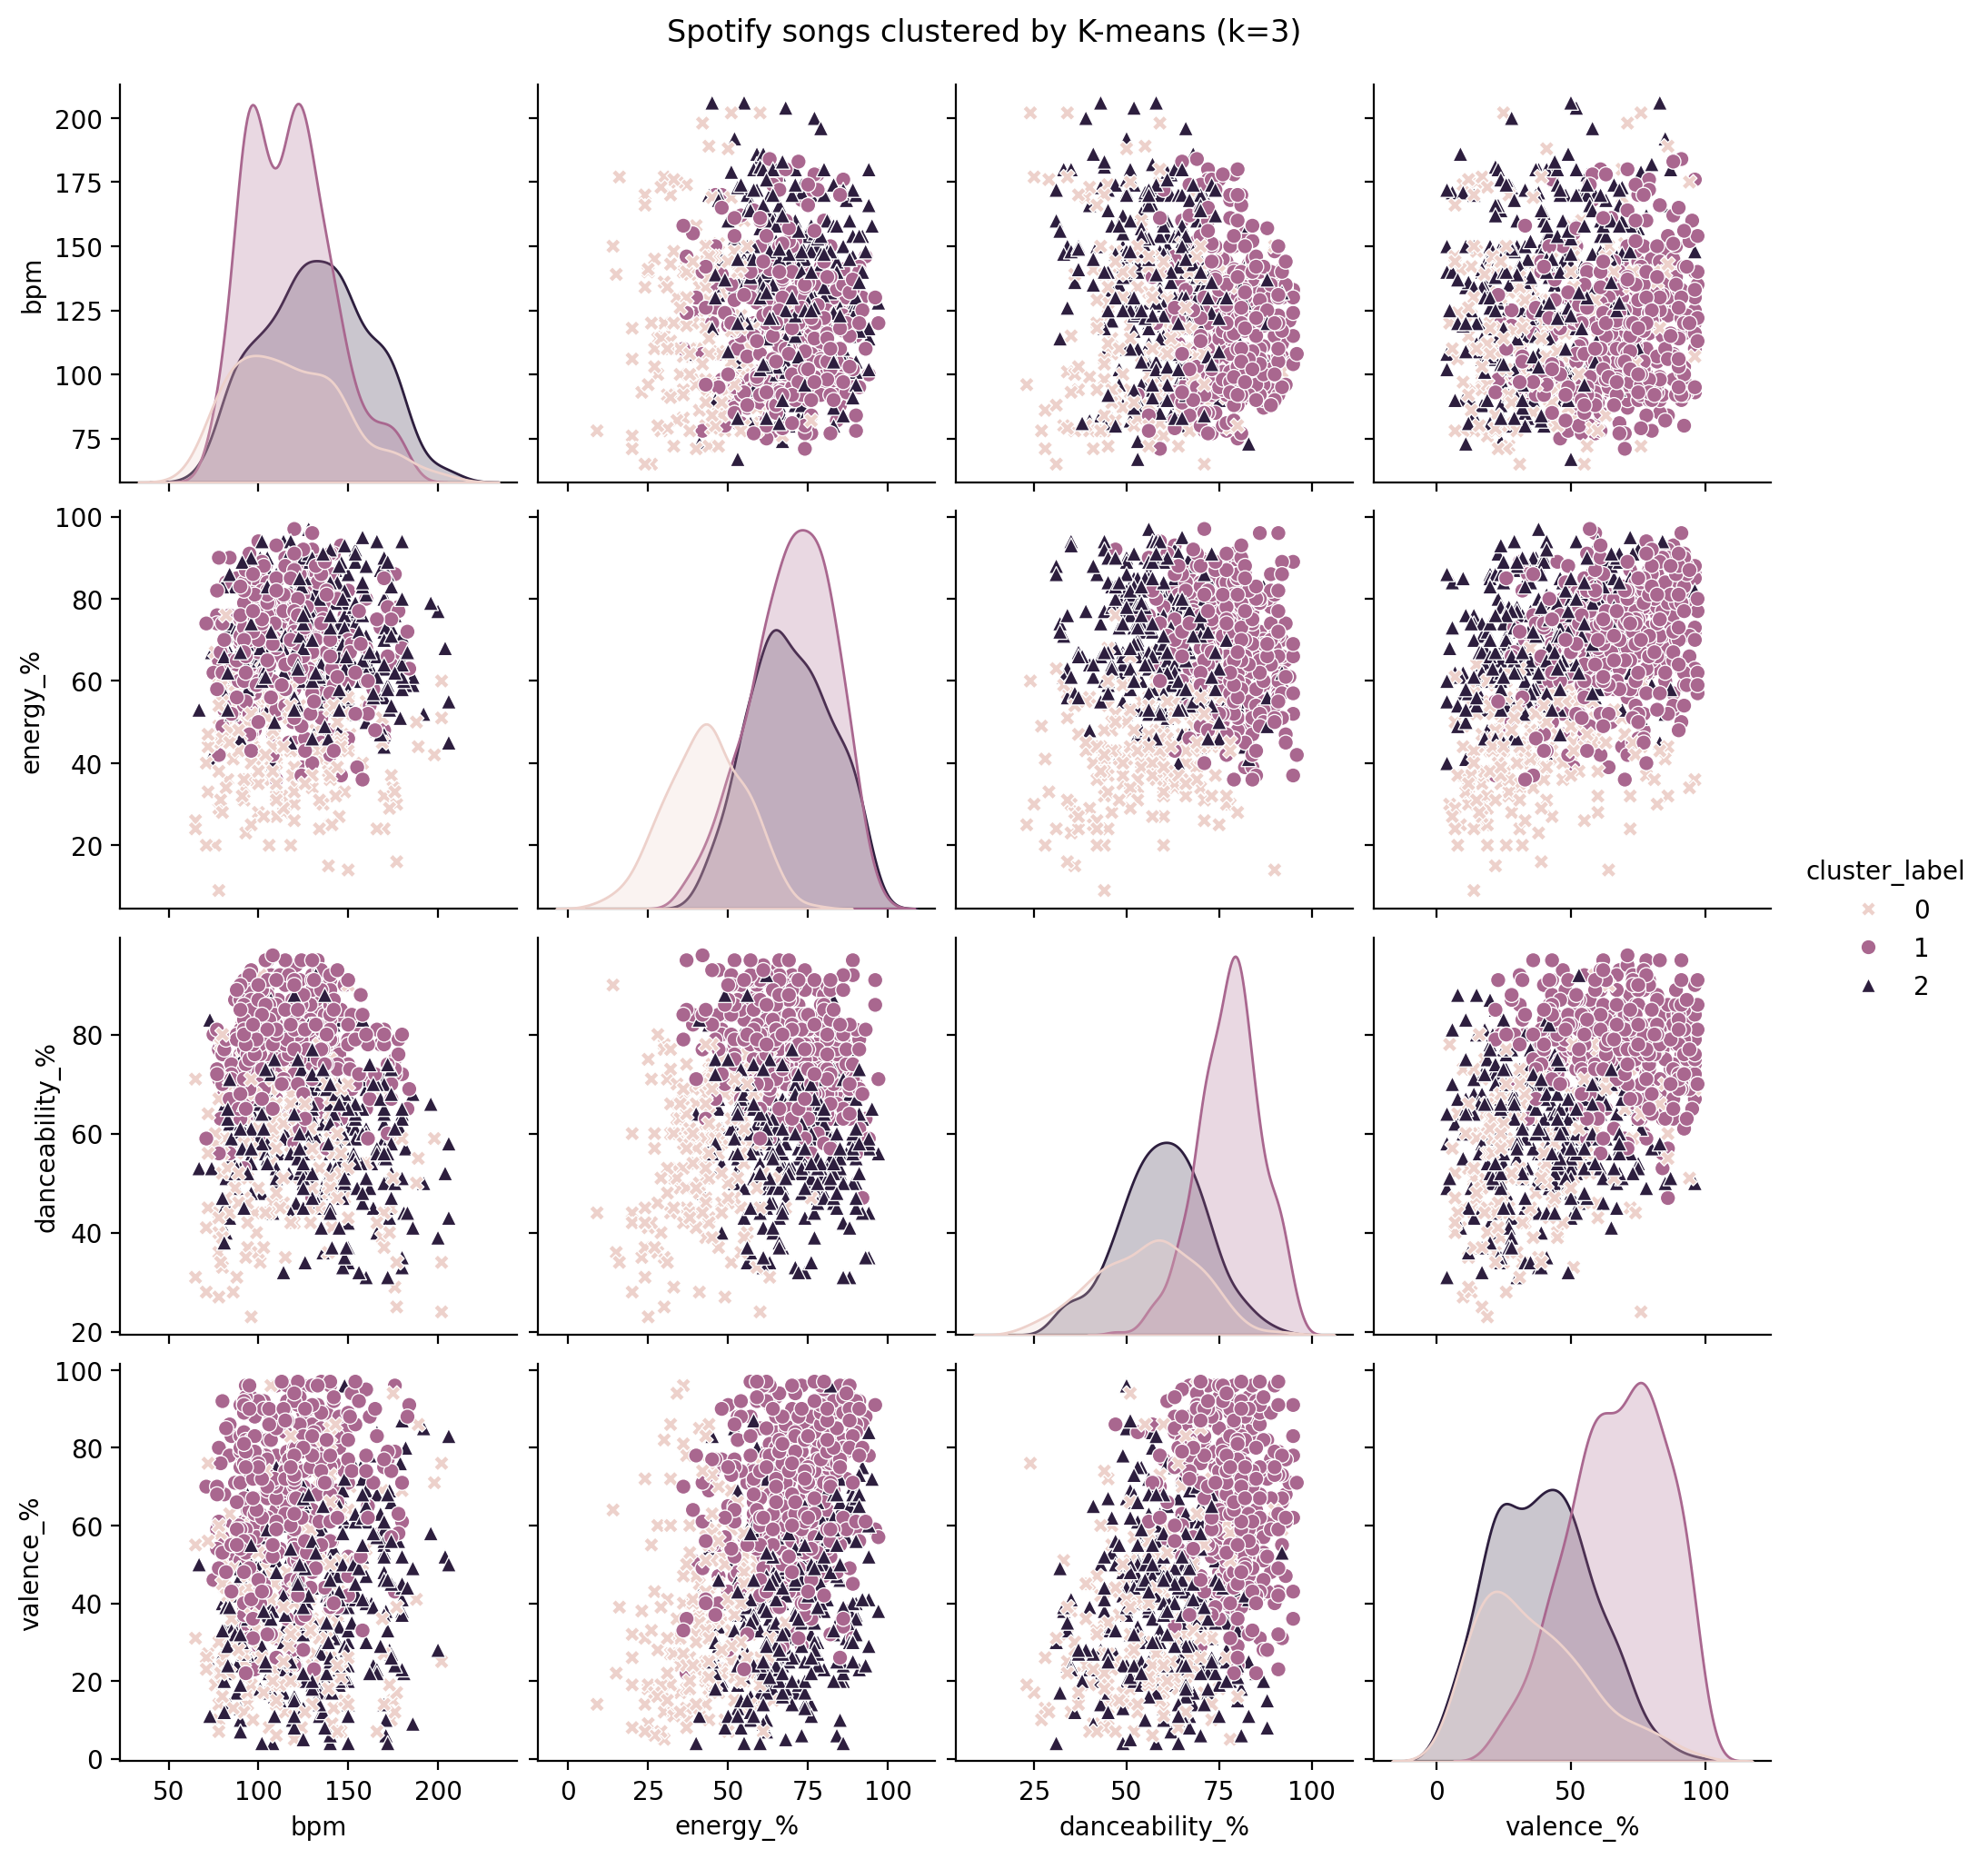

In [14]:
sns.pairplot(
    vars=["bpm", "energy_%", "danceability_%", "valence_%"], 
    hue="cluster_label",
    data=spotify_df,
    diag_kind="kde",
    markers=["X", "o", "^"]  
)
plt.suptitle(f"Spotify songs clustered by K-means (k={BEST_K})", y=1.02)
plt.show()

We choose the four features bpm, energy, danceability, and valence because they are the most interpretable musically:
* bpm: shows tempo, strongly separates fast vs. slow songs
* energy: high energy vs chill songs
* danceability: groups dance pop songs separately from acoustic songs
* valence: measures "happy vs. sad"

These features provide the most interpretable axes for understanding musical similarity, they clearly separate songs by tempo, intensity, rhythm, and mood.

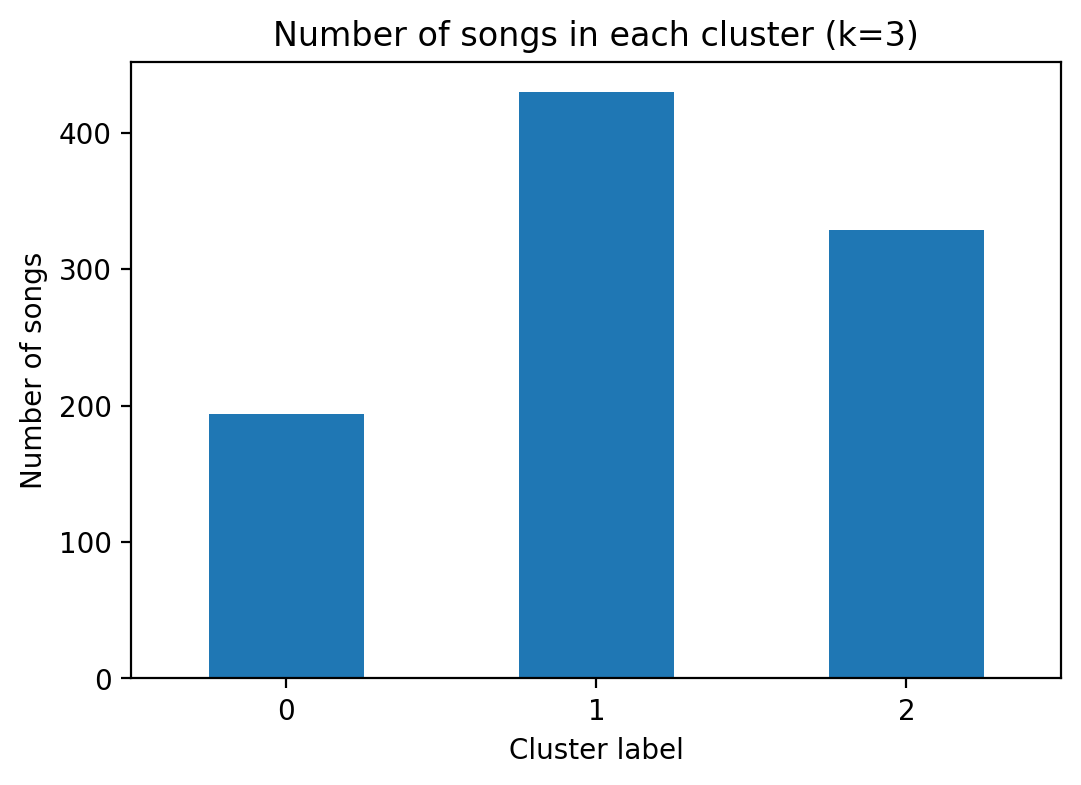

In [15]:
cluster_counts = spotify_df["cluster_label"].value_counts().sort_index()

plt.figure(figsize=(6, 4))
cluster_counts.plot(kind="bar")
plt.xlabel("Cluster label")
plt.ylabel("Number of songs")
plt.title(f"Number of songs in each cluster (k={BEST_K})")
plt.xticks(rotation=0)
plt.show()

## Phase 5 - Inspect cluster results ##

In [16]:
cluster_summary = spotify_df.groupby("cluster_label")[audio_features].mean()
cluster_summary.head()

,bpm,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%
cluster_label,,,,,,,,
0,117.458763,55.556701,36.402062,43.015464,64.134021,4.649485,15.994845,7.659794
1,117.348837,77.762791,67.406977,69.900000,21.427907,0.374419,15.620930,12.458140
2,132.322188,59.592705,39.413374,69.471125,12.553191,1.349544,22.908815,8.547112


**Cluster 0 - Acoustic/Low-Energy/Emotional & Chill** 
* High acousticness
* Low energy
* Low valence (more sad and reflective)
* Moderate danceability

**Cluster 1 - High Energy Dance Pop/Happy/Mainstream**
* Very high danceability
* High energy
* Highest valence (happy and upbeat)
* Low acousticness
* Moderate speechiness (pop and rap blends)

**Cluster 2 - High BPM Energetic/Edgy/Electronic**
* Highest BPM
* High energy
* Low valence
* Low acousticness
* High liveness

## Phase 6 - Testing (finding similar songs in the same cluster) ##

Recommend songs from the same cluster as the seed song, ranked by Euclidean distance in scaled feature space.

In [17]:
def recommend_similar_songs(spotify_df, audio_features, cl_pipe,
                            seed_track, seed_artist=None, top_n=5):

    # Find seed song
    mask = spotify_df["track_name"].str.lower() == seed_track.lower()
    if seed_artist is not None:
        mask &= spotify_df["artist(s)_name"].str.lower().str.contains(seed_artist.lower())
    
    seed_df = spotify_df[mask]
    if seed_df.empty:
        raise ValueError("Seed song not found. Check track name / artist.")
    
    seed_idx = seed_df.index[0]
    seed_cluster = spotify_df.loc[seed_idx, "cluster_label"]
    
    # Filter other songs in same cluster
    same_cluster = spotify_df[
        (spotify_df["cluster_label"] == seed_cluster) &
        (spotify_df.index != seed_idx)
    ]
    if same_cluster.empty:
        raise ValueError("No other songs found in the same cluster.")
    
    # Get scaled features using the scaler from the pipeline
    scaler = cl_pipe.named_steps["scale"]
    X_scaled = scaler.transform(spotify_df[audio_features])
    
    # Map DataFrame index to position in X_scaled
    index_to_pos = {idx: pos for pos, idx in enumerate(spotify_df.index)}
    
    # Seed vector
    seed_pos = index_to_pos[seed_idx]
    seed_vec = X_scaled[seed_pos]
    
    # Compute distances to songs in same cluster
    distances = []
    for idx in same_cluster.index:
        pos = index_to_pos[idx]
        vec = X_scaled[pos]
        dist = np.linalg.norm(seed_vec - vec)
        distances.append((idx, dist))
    
    # 5. Sort by distance and pick top_n
    distances.sort(key=lambda x: x[1])
    top_indices = [idx for idx, _ in distances[:top_n]]
    
    return spotify_df.loc[top_indices, ["track_name", "artist(s)_name", "cluster_label"] + audio_features]

**Test Case: deja vu by Olivia Rodrigo**

In [18]:
seed_track = "deja vu"        
seed_artist = "Olivia Rodrigo"   
recs = recommend_similar_songs(
    spotify_df=spotify_df,
    audio_features=audio_features,
    cl_pipe=cl_pipe,
    seed_track=seed_track,
    seed_artist=seed_artist,
    top_n=5
)

print("Seed song:", seed_track, "-", seed_artist)
print("\nRecommended similar songs from the same cluster:")
display(recs)

Seed song: deja vu - Olivia Rodrigo

Recommended similar songs from the same cluster:


/opt/anaconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


,track_name,artist(s)_name,cluster_label,bpm,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%
289,Don't ever say love me (feat. RM of BTS),"RM, Colde",2,145,54,19,48,36,0,37,5
173,Demons,Imagine Dragons,2,180,33,38,71,20,0,28,5
651,Boyfriend,Dove Cameron,2,180,35,23,61,23,0,19,6
514,"Here We Goï¿½ï¿½ï¿½ Again (feat. Tyler, the Cr","The Weeknd, Tyler, The Creator",2,135,41,27,64,36,0,60,3
292,Call Out My Name,The Weeknd,2,134,45,17,60,21,0,33,4


**Test Case: Labyrinth by Taylor Swift**

In [19]:
seed_track = "Labyrinth"        
seed_artist = "Taylor Swift"   
recs = recommend_similar_songs(
    spotify_df=spotify_df,
    audio_features=audio_features,
    cl_pipe=cl_pipe,
    seed_track=seed_track,
    seed_artist=seed_artist,
    top_n=5
)

print("Seed song:", seed_track, "-", seed_artist)
print("\nRecommended similar songs from the same cluster:")
display(recs)

Seed song: Labyrinth - Taylor Swift

Recommended similar songs from the same cluster:


/opt/anaconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


,track_name,artist(s)_name,cluster_label,bpm,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%
577,Phantom Regret by Jim,The Weeknd,0,108,46,23,48,75,30,14,4
96,Say Yes To Heaven,Lana Del Rey,0,100,49,17,35,71,9,11,3
72,golden hour,JVKE,0,94,51,14,59,65,18,25,3
606,Pope Is a Rockstar,SALES,0,90,73,31,45,85,24,11,3
942,Con La Brisa,"Ludwig Goransson, Foudeqush",0,114,62,25,44,51,33,14,3


**Test Case: Butter by BTS**

In [20]:
seed_track = "Butter"        
seed_artist = "BTS"   
recs = recommend_similar_songs(
    spotify_df=spotify_df,
    audio_features=audio_features,
    cl_pipe=cl_pipe,
    seed_track=seed_track,
    seed_artist=seed_artist,
    top_n=5
)

print("Seed song:", seed_track, "-", seed_artist)
print("\nRecommended similar songs from the same cluster:")
display(recs) 

Seed song: Butter - BTS

Recommended similar songs from the same cluster:


/opt/anaconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


,track_name,artist(s)_name,cluster_label,bpm,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%
213,FLOWER,JISOO,1,124,84,64,39,3,0,11,4
508,How Do I Make You Love Me?,The Weeknd,1,121,80,62,51,2,0,9,8
386,Shirt,SZA,1,120,82,55,45,15,3,9,10
693,Seï¿½ï¿½o,"Shawn Mendes, Camila Cabello",1,117,76,77,52,4,0,8,3
700,Una Noche en Medellï¿½,Cris Mj,1,96,87,82,53,10,0,5,8
